In this example, we will figure out what's better: HODLing Bitcoin, trading randomly, or using DMAC strategy. We will also compare thousands of window combinations to understand how profit varies with window size and trends.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.parser import parse
import ipywidgets as widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly.graph_objects as go
import itertools
import dateparser
import yfinance as yf

In [3]:
# Enter your parameters here
seed = 42
asset_name = 'BTC-USD'
metric = 'total_return'

start_date = datetime(2018, 1, 1) # time period for analysis
end_date = datetime.now()
time_buffer = timedelta(days=100) # buffer before to pre-calculate SMA/EMA, best to set to max window

vbt.defaults.portfolio['init_capital'] = 100 # in $
vbt.defaults.portfolio['fees'] = 0.0025 # in %
vbt.defaults.portfolio['slippage'] = 0.0025 # in %

In [4]:
# Download data with time buffer
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_wbuf = yf.Ticker(asset_name).history(start=start_date-time_buffer, end=end_date)
ohlcv_wbuf = ohlcv_wbuf[ohlcv_cols].astype(np.float64)
    
print(ohlcv_wbuf.shape)
print(ohlcv_wbuf.columns)

(950, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [5]:
# Create a copy of data without time buffer
wobuf_mask = (ohlcv_wbuf.index >= start_date) & (ohlcv_wbuf.index <= end_date) # mask without buffer

ohlcv = ohlcv_wbuf.loc[wobuf_mask, :]

print(ohlcv.shape)

(849, 5)


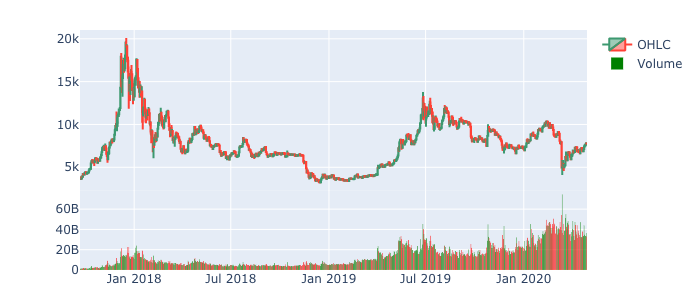

In [6]:
# Plot the OHLC data
ohlcv_wbuf.vbt.ohlcv.plot().show_png() 
# remove show_png() to display interactive chart!

## Single window combination

Perform a single test to see how our DMAC strategy compares to the hold strategy.

In [7]:
fast_window = 30
slow_window = 80

In [8]:
# Pre-calculate running windows on data with time buffer
fast_ma = vbt.MA.from_params(ohlcv_wbuf['Open'], fast_window)
slow_ma = vbt.MA.from_params(ohlcv_wbuf['Open'], slow_window)

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(950,)
(950,)


In [9]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

# there should be no nans after removing time buffer
assert(~fast_ma.ma.isnull().any()) 
assert(~slow_ma.ma.isnull().any())

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(849,)
(849,)


In [10]:
# Generate crossover signals
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

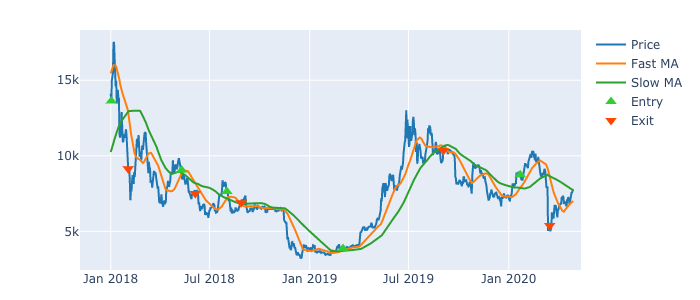

In [11]:
fig = ohlcv['Open'].vbt.timeseries.plot(name='Price')
fig = fast_ma.ma.vbt.timeseries.plot(name='Fast MA', fig=fig)
fig = slow_ma.ma.vbt.timeseries.plot(name='Slow MA', fig=fig)
fig = dmac_entries.vbt.signals.plot_markers(ohlcv['Open'], signal_type='entry', fig=fig)
fig = dmac_exits.vbt.signals.plot_markers(ohlcv['Open'], signal_type='exit', fig=fig)

fig.show_png()

In [12]:
# Distribution of signals
print(dmac_entries.vbt.signals.num_signals, dmac_exits.vbt.signals.num_signals)
print(dmac_entries.vbt.signals.avg_distance, dmac_exits.vbt.signals.avg_distance)
print(dmac_entries.vbt.signals.avg_distance_to(dmac_exits))

5 5
187.5 193.25
64.0


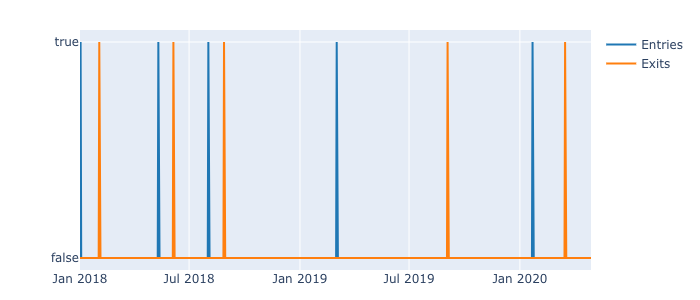

In [13]:
# Plot signals
fig = dmac_entries.vbt.signals.plot(name='Entries')
dmac_exits.vbt.signals.plot(name='Exits', fig=fig).show_png()

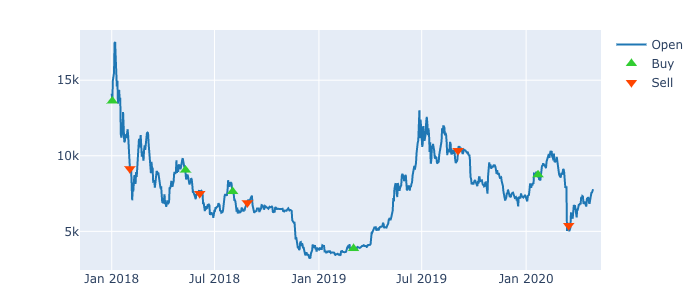

In [14]:
# Build partfolio, which internally calculates the equity curve
# Volume is set to np.inf to buy/sell everything
dmac_portfolio = vbt.Portfolio.from_signals(ohlcv['Open'], dmac_entries, dmac_exits)

dmac_portfolio.plot_trades().show_png()

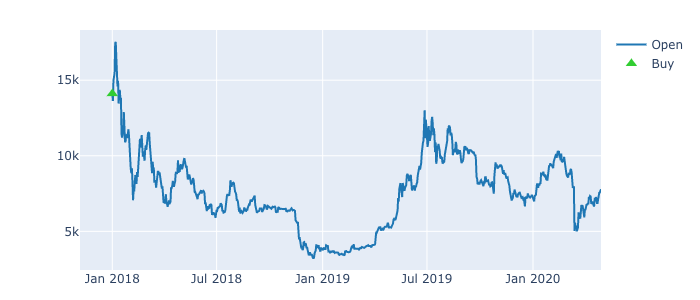

In [15]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and never sell
hold_entries = pd.Series.vbt.signals.empty_like(dmac_entries)
hold_entries.iloc[0] = True
hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
hold_portfolio = vbt.Portfolio.from_signals(ohlcv['Open'], hold_entries, hold_exits)

hold_portfolio.plot_trades().show_png()

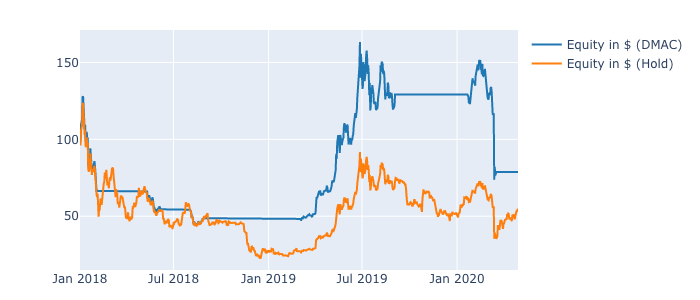

In [16]:
# Equity in $
fig = dmac_portfolio.equity.vbt.timeseries.plot(name='Equity in $ (DMAC)')
hold_portfolio.equity.vbt.timeseries.plot(name='Equity in $ (Hold)', fig=fig).show_png()

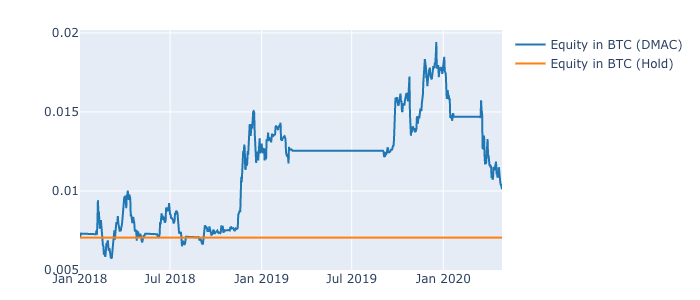

In [17]:
# Equity measured in Bitcoins
fig = dmac_portfolio.equity_in_shares.vbt.timeseries.plot(name='Equity in BTC (DMAC)')
hold_portfolio.equity_in_shares.vbt.timeseries.plot(name='Equity in BTC (Hold)', fig=fig).show_png()

Now we will implement an interactive window slider to easily compare windows by their performance.

In [18]:
min_window = 2
max_window = 100

In [19]:
perf_metrics = ['total_return', 'win_rate', 'mdd']
perf_metric_names = ['Total return', 'Win rate', 'Max drawdown']

windows_slider = widgets.IntRangeSlider(
    value=[fast_window, slow_window],
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)
dmac_fig = None
dmac_img = widgets.Image(
    format='png',
    width=vbt.defaults.layout['width'],
    height=vbt.defaults.layout['height']
)
metrics_html = widgets.HTML()

def on_value_change(value):
    global dmac_fig
    
    # Calculate portfolio
    fast_window, slow_window = value['new']
    fast_ma = vbt.MA.from_params(ohlcv_wbuf['Open'], fast_window)
    slow_ma = vbt.MA.from_params(ohlcv_wbuf['Open'], slow_window)
    fast_ma = fast_ma[wobuf_mask]
    slow_ma = slow_ma[wobuf_mask]
    dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
    dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)
    dmac_portfolio = vbt.Portfolio.from_signals(ohlcv['Open'], dmac_entries, dmac_exits)

    # Update figure
    if dmac_fig is None:
        dmac_fig = ohlcv['Open'].vbt.timeseries.plot(name='Price')
        fast_ma.ma.vbt.timeseries.plot(name='Fast MA', fig=dmac_fig)
        slow_ma.ma.vbt.timeseries.plot(name='Slow MA', fig=dmac_fig)
        dmac_entries.vbt.signals.plot_markers(ohlcv['Open'], signal_type='entry', fig=dmac_fig)
        dmac_exits.vbt.signals.plot_markers(ohlcv['Open'], signal_type='exit', fig=dmac_fig)
    else:
        with crossover_fig.batch_update():
            dmac_fig.data[1].y = fast_ma.ma
            dmac_fig.data[2].y = slow_ma.ma
            dmac_fig.data[3].x = ohlcv['Open'].index[dmac_entries]
            dmac_fig.data[3].y = ohlcv['Open'][dmac_entries]
            dmac_fig.data[4].x = ohlcv['Open'].index[dmac_exits]
            dmac_fig.data[4].y = ohlcv['Open'][dmac_exits]
    dmac_img.value = dmac_fig.to_image(format="png")
    
    # Update metrics table
    sr = pd.Series([getattr(dmac_portfolio, m) for m in perf_metrics], index=perf_metric_names, name='Performance')
    metrics_html.value = sr.to_frame().style.set_properties(**{'text-align': 'right'}).render()
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value})

widgets.VBox([
    widgets.HBox([widgets.Label('Fast and slow window:'), windows_slider]),
    dmac_img,
    metrics_html
])

In [20]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

## Multiple window combinations

Calculate the performance of each window combination in a vectorized way and display the results as a heatmap.

In [21]:
%%time
# Pre-calculate running windows on data with time buffer
fast_ma, slow_ma = vbt.MA.from_combinations(ohlcv_wbuf['Open'], 
    np.arange(min_window, max_window+1), 2, ewm=False, names=['fast_ma', 'slow_ma'])

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)
print(fast_ma.ma.columns)
print(slow_ma.ma.columns)

(950, 4851)
(950, 4851)
MultiIndex([( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ( 2, False),
            ...
            (96, False),
            (96, False),
            (96, False),
            (96, False),
            (97, False),
            (97, False),
            (97, False),
            (98, False),
            (98, False),
            (99, False)],
           names=['fast_ma_window', 'fast_ma_ewm'], length=4851)
MultiIndex([(  3, False),
            (  4, False),
            (  5, False),
            (  6, False),
            (  7, False),
            (  8, False),
            (  9, False),
            ( 10, False),
            ( 11, False),
            ( 12, False),
            ...
            ( 97, False),
            ( 98, False),
            ( 99, False),
            (100, False),
            ( 

In [22]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(849, 4851)
(849, 4851)


In [23]:
# We perform the same steps, but now we have 4851 columns instead of 1
# Each column corresponds to a pair of fast and slow windows
# Generate crossover signals
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

print(dmac_entries.columns) # the same for dmac_exits

MultiIndex([( 2, False,   3, False),
            ( 2, False,   4, False),
            ( 2, False,   5, False),
            ( 2, False,   6, False),
            ( 2, False,   7, False),
            ( 2, False,   8, False),
            ( 2, False,   9, False),
            ( 2, False,  10, False),
            ( 2, False,  11, False),
            ( 2, False,  12, False),
            ...
            (96, False,  97, False),
            (96, False,  98, False),
            (96, False,  99, False),
            (96, False, 100, False),
            (97, False,  98, False),
            (97, False,  99, False),
            (97, False, 100, False),
            (98, False,  99, False),
            (98, False, 100, False),
            (99, False, 100, False)],
           names=['fast_ma_window', 'fast_ma_ewm', 'slow_ma_window', 'slow_ma_ewm'], length=4851)


In [24]:
# Build portfolio
dmac_portfolio = vbt.Portfolio.from_signals(ohlcv['Open'], dmac_entries, dmac_exits)

In [25]:
# Calculate performance of each window combination
dmac_perf = getattr(dmac_portfolio, metric)

print(dmac_perf.shape)
print(dmac_perf.index)

(4851,)
MultiIndex([( 2, False,   3, False),
            ( 2, False,   4, False),
            ( 2, False,   5, False),
            ( 2, False,   6, False),
            ( 2, False,   7, False),
            ( 2, False,   8, False),
            ( 2, False,   9, False),
            ( 2, False,  10, False),
            ( 2, False,  11, False),
            ( 2, False,  12, False),
            ...
            (96, False,  97, False),
            (96, False,  98, False),
            (96, False,  99, False),
            (96, False, 100, False),
            (97, False,  98, False),
            (97, False,  99, False),
            (97, False, 100, False),
            (98, False,  99, False),
            (98, False, 100, False),
            (99, False, 100, False)],
           names=['fast_ma_window', 'fast_ma_ewm', 'slow_ma_window', 'slow_ma_ewm'], length=4851)


In [26]:
dmac_perf.idxmax() # your optimal window combination

(18, False, 21, False)

In [27]:
# Convert this array into a matrix of shape (99, 99): 99 fast windows x 99 slow windows
dmac_perf_matrix = dmac_perf.vbt.unstack_to_df(symmetric=True, 
    index_levels='fast_ma_window', column_levels='slow_ma_window')

print(dmac_perf_matrix.shape)

(99, 99)


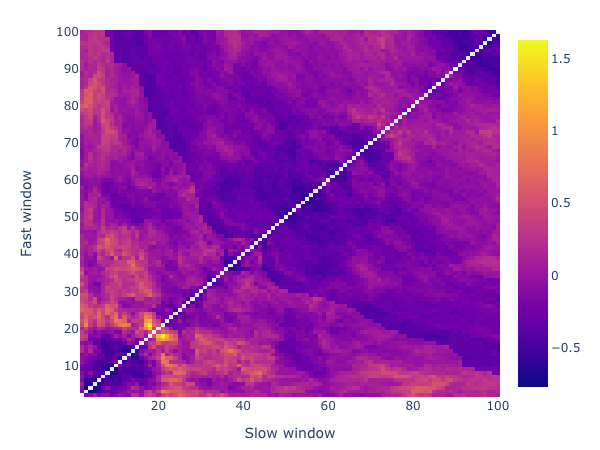

In [28]:
dmac_perf_matrix.vbt.Heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window', 
    width=600, height=450).show_png() 
# remove show_png() for interactivity

Now we will implement an interactive date range slider to easily compare heatmaps over time.

In [29]:
def dmac_portfolio_from_date_range(from_date, to_date):
    # Portfolio from MA crossover, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    range_fast_ma = fast_ma[range_mask] # use our variables defined above
    range_slow_ma = slow_ma[range_mask]
    dmac_entries = range_fast_ma.ma_above(range_slow_ma, crossover=True)
    dmac_exits = range_fast_ma.ma_below(range_slow_ma, crossover=True)
    dmac_portfolio = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Open'], dmac_entries, dmac_exits)
    return dmac_portfolio

%time dmac_portfolio_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).equity.shape

CPU times: user 510 ms, sys: 125 ms, total: 634 ms
Wall time: 675 ms


(849, 4851)

In [30]:
def rand_portfolio_from_date_range(from_date, to_date):
    # Portfolio from random strategy, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    range_fast_ma = fast_ma[range_mask] # use our variables defined above
    range_slow_ma = slow_ma[range_mask]
    dmac_entries = range_fast_ma.ma_above(range_slow_ma, crossover=True)
    dmac_exits = range_fast_ma.ma_below(range_slow_ma, crossover=True)
    rand_entries = dmac_entries.vbt.signals.shuffle(seed=seed) # same number of signals as in dmac
    rand_exits = rand_entries.vbt.signals.random_exits(1, seed=seed)
    rand_portfolio = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Open'], rand_entries, rand_exits)
    return rand_portfolio

%time rand_portfolio_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).equity.shape

CPU times: user 852 ms, sys: 165 ms, total: 1.02 s
Wall time: 1.36 s


(849, 4851)

In [31]:
def hold_portfolio_from_date_range(from_date, to_date):
    # Portfolio from holding strategy, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    hold_entries = pd.Series.vbt.signals.empty(range_mask.sum(), index=ohlcv[range_mask].index)
    hold_entries.iloc[0] = True
    hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
    hold_portfolio = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Open'], hold_entries, hold_exits)
    return hold_portfolio

%time hold_portfolio_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).equity.shape

CPU times: user 26.3 ms, sys: 1.84 ms, total: 28.2 ms
Wall time: 48.8 ms


(849,)

In [32]:
# TimeSeries (OHLC)
ts_fig = ohlcv.vbt.ohlcv.plot(
    title=asset_name, 
    display_volume=False,
    annotations=[dict(
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0.5,
        y=0.9,
        font=dict(size=14),
        bordercolor='black',
        borderwidth=1,
        bgcolor='white'
    )],
    width=750, 
    height=200)

# Histogram (DMAC vs Random)
histogram_fig = vbt.Histogram(
    ['Random strategy', 'DMAC strategy'],
    title='%s distribution' % metric,
    xaxis_tickformat='%',
    annotations=[dict(
        y=0, 
        xref='x', 
        yref='paper', 
        showarrow=True, 
        xanchor='left', 
        text='Holding', 
        font=dict(size=14),
        bordercolor='black',
        borderwidth=1,
        bgcolor='white'
    )],
    width=750,
    height=200
)

# Heatmap (DMAC vs Holding)
heatmap_fig = vbt.Heatmap(
    np.arange(min_window, max_window+1),
    np.arange(min_window, max_window+1),
    trace_kwargs=dict(
        colorbar=dict(
            tickformat='%', 
            ticks="outside"
        ), 
        colorscale='RdBu'),
    title='%s by window' % metric,
    width=650,
    height=420
)

dmac_perf_matrix = None
rand_perf_matrix = None
hold_value = None

def update_heatmap_colorscale(perf_matrix):
    # Update heatmap colorscale based on performance matrix
    heatmap_fig.data[0].zmid = hold_value
    heatmap_fig.data[0].colorbar.tickvals = [
        np.nanmin(perf_matrix), 
        hold_value, 
        np.nanmax(perf_matrix)
    ]
    heatmap_fig.data[0].colorbar.ticktext = [
        'Min: {:.0%}'.format(np.nanmin(perf_matrix)).ljust(12), 
        'Hold: {:.0%}'.format(hold_value).ljust(12), 
        'Max: {:.0%}'.format(np.nanmax(perf_matrix)).ljust(12)
    ]
    
def update_histogram(dmac_perf_matrix, rand_perf_matrix, hold_value):
    # Update histogram figure
    with histogram_fig.batch_update():
        histogram_fig.update_data(np.asarray([
            rand_perf_matrix.values.flatten(),
            dmac_perf_matrix.values.flatten()
        ]).transpose())
        histogram_fig.layout.annotations[0].x = hold_value

def update_figs(from_date, to_date):
    global dmac_perf_matrix, rand_perf_matrix, hold_value # needed for on_heatmap_change
    
    # Build portfolios
    dmac_portfolio = dmac_portfolio_from_date_range(from_date, to_date)
    rand_portfolio = rand_portfolio_from_date_range(from_date, to_date)
    hold_portfolio = hold_portfolio_from_date_range(from_date, to_date)

    # Calculate performance
    dmac_perf_matrix = getattr(dmac_portfolio, metric)
    dmac_perf_matrix = dmac_perf_matrix.vbt.unstack_to_df(
        symmetric=True, index_levels='fast_ma_window', column_levels='slow_ma_window')
    rand_perf_matrix = getattr(rand_portfolio, metric)
    rand_perf_matrix = rand_perf_matrix.vbt.unstack_to_df(
        symmetric=True, index_levels='fast_ma_window', column_levels='slow_ma_window')
    hold_value = getattr(hold_portfolio, metric)

    # Update figures
    update_histogram(dmac_perf_matrix, rand_perf_matrix, hold_value)
    with ts_fig.batch_update():
        ts_fig.update_xaxes(range=(from_date, to_date))
        ts_fig.layout.annotations[0].text = 'Hold: %.f%%' % (hold_value * 100)
    with heatmap_fig.batch_update():
        heatmap_fig.update_data(dmac_perf_matrix)
        update_heatmap_colorscale(dmac_perf_matrix.values)

def on_ts_change(layout, x_range):
    global dmac_perf_matrix, rand_perf_matrix, hold_value # needed for on_heatmap_change
    
    if isinstance(x_range[0], str) and isinstance(x_range[1], str):
        from_date, to_date = dateparser.parse(x_range[0]), dateparser.parse(x_range[1])
        update_figs(from_date, to_date)

ts_fig.layout.on_change(on_ts_change, 'xaxis.range')

def on_heatmap_change(layout, x_range, y_range):
    if dmac_perf_matrix is not None:
        x_mask = (dmac_perf_matrix.columns >= x_range[0]) & (dmac_perf_matrix.columns <= x_range[1])
        y_mask = (dmac_perf_matrix.index >= y_range[0]) & (dmac_perf_matrix.index <= y_range[1])
        if x_mask.any() and y_mask.any():
            # Update widgets
            sub_dmac_perf_matrix = dmac_perf_matrix.loc[y_mask, x_mask] # y_mask is index, x_mask is columns
            sub_rand_perf_matrix = rand_perf_matrix.loc[y_mask, x_mask]
            update_histogram(sub_dmac_perf_matrix, sub_rand_perf_matrix, hold_value)
            with heatmap_fig.batch_update():
                update_heatmap_colorscale(sub_dmac_perf_matrix.values)
        
heatmap_fig.layout.on_change(on_heatmap_change, 'xaxis.range', 'yaxis.range')

widgets.VBox([
    ts_fig,
    histogram_fig,
    heatmap_fig
])

    'data': [{'close': array([13657.2 , 14982.1 , 15201.  , ...,  7679.87,  7795…

In [33]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

Animate the whole thing as a GIF.

In [34]:
def hstack_images(a, b):
    h1, w1, d = a.shape
    h2, w2, _ = b.shape
    c = np.full((max(h1, h2), w1 + w2, d), 255, np.uint8)
    c[:h1, :w1, :] = a
    c[:h2, w1:w1+w2, :] = b
    return c

def vstack_images(a, b):
    h1, w1, d = a.shape
    h2, w2, _ = b.shape
    c = np.full((h1 + h2, max(w1, w2), d), 255, np.uint8)
    c[:h1, :w1, :] = a
    c[h1:h1+h2, :w2, :] = b
    return c

In [35]:
gif_date_delta = timedelta(days=365)
gif_step = 4
gif_fps = 5
gif_fname = 'dmac_heatmap.gif'

img_arrays = []
index = ohlcv.index[ohlcv.index <= ohlcv.index[-1] - gif_date_delta]

histogram_fig.update_xaxes(range=[-1, 5])

with imageio.get_writer(gif_fname, fps=gif_fps) as writer:
    for i in tqdm(range(0, len(index), gif_step)):
        from_date = index[i]
        to_date = from_date + gif_date_delta
        # Update figures
        update_figs(from_date, to_date)
        # Convert them to png and then to numpy arrays
        ts_np = imageio.imread(ts_fig.to_image(format="png"))
        histogram_np = imageio.imread(histogram_fig.to_image(format="png"))
        heatmap_np = imageio.imread(heatmap_fig.to_image(format="png"))
        # Stack them vertically
        img_np = vstack_images(vstack_images(ts_np, histogram_np), heatmap_np)
        writer.append_data(img_np)

100%|██████████| 121/121 [02:35<00:00,  1.21s/it]


## Strategy comparison

To compare multiple strategies, we need to find out their performance over multiple time ranges. To do this, we will roll a fixed date range over price, and calculate the performance matrix (think of the heatmap we played with above) for each time range. We will then stack those matrices together to form a cube. You can then easily reduce this cube along the time range axis to compare window combinations or along the both combination axes to compare strategies. The more time ranges you include, the more statistically significant are your findings, but also the more memory the calculation will occupy.

This is similar to a GIF animation (stacks heatmaps into a cube) but in raw form and a fully vectorized way!

In [36]:
ts_window = timedelta(days=365)
ts_window_n = 50 # split the whole period into 50 (overlapping) time ranges

In [37]:
# Roll a window over price
# Creates a matrix with columns being time series of length ts_window
# We need buffer here, otherwise first elements will be NaNs
open_roll_wbuf = ohlcv_wbuf['Open'].vbt.timeseries.rolling_window((ts_window + time_buffer).days, n=ts_window_n)

print(open_roll_wbuf.shape)
print(open_roll_wbuf.columns)

(465, 50)
DatetimeIndex(['2017-09-22', '2017-10-02', '2017-10-12', '2017-10-22',
               '2017-11-01', '2017-11-10', '2017-11-20', '2017-11-30',
               '2017-12-10', '2017-12-20', '2017-12-30', '2018-01-09',
               '2018-01-19', '2018-01-29', '2018-02-08', '2018-02-17',
               '2018-02-27', '2018-03-09', '2018-03-19', '2018-03-29',
               '2018-04-08', '2018-04-18', '2018-04-28', '2018-05-08',
               '2018-05-18', '2018-05-27', '2018-06-06', '2018-06-16',
               '2018-06-26', '2018-07-06', '2018-07-16', '2018-07-26',
               '2018-08-05', '2018-08-15', '2018-08-25', '2018-09-03',
               '2018-09-13', '2018-09-23', '2018-10-03', '2018-10-13',
               '2018-10-23', '2018-11-02', '2018-11-12', '2018-11-22',
               '2018-12-02', '2018-12-11', '2018-12-21', '2018-12-31',
               '2019-01-10', '2019-01-20'],
              dtype='datetime64[ns]', name='start_date', freq=None)


In [38]:
%%time
# This will calculate moving averages for all date ranges and window combinations
fast_ma_roll, slow_ma_roll = vbt.MA.from_combinations(open_roll_wbuf, 
    np.arange(min_window, max_window+1), 2, ewm=False, names=['fast_ma', 'slow_ma'])

print(fast_ma_roll.ma.shape)
print(slow_ma_roll.ma.shape)
print(fast_ma_roll.ma.columns)
print(slow_ma_roll.ma.columns)

(465, 242550)
(465, 242550)
MultiIndex([( 2, False, '2017-09-22'),
            ( 2, False, '2017-10-02'),
            ( 2, False, '2017-10-12'),
            ( 2, False, '2017-10-22'),
            ( 2, False, '2017-11-01'),
            ( 2, False, '2017-11-10'),
            ( 2, False, '2017-11-20'),
            ( 2, False, '2017-11-30'),
            ( 2, False, '2017-12-10'),
            ( 2, False, '2017-12-20'),
            ...
            (99, False, '2018-10-23'),
            (99, False, '2018-11-02'),
            (99, False, '2018-11-12'),
            (99, False, '2018-11-22'),
            (99, False, '2018-12-02'),
            (99, False, '2018-12-11'),
            (99, False, '2018-12-21'),
            (99, False, '2018-12-31'),
            (99, False, '2019-01-10'),
            (99, False, '2019-01-20')],
           names=['fast_ma_window', 'fast_ma_ewm', 'start_date'], length=242550)
MultiIndex([(  3, False, '2017-09-22'),
            (  3, False, '2017-10-02'),
            ( 

In [39]:
# Remove time buffer
fast_ma_roll = fast_ma_roll.iloc[time_buffer.days:]
slow_ma_roll = slow_ma_roll.iloc[time_buffer.days:]

print(fast_ma_roll.ma.shape)
print(slow_ma_roll.ma.shape)

(365, 242550)
(365, 242550)


In [40]:
# Generate crossover signals
dmac_entries_roll = fast_ma_roll.ma_above(slow_ma_roll, crossover=True)
dmac_exits_roll = fast_ma_roll.ma_below(slow_ma_roll, crossover=True)

print(dmac_entries_roll.shape)
print(dmac_exits_roll.shape)
print(dmac_entries_roll.columns)

(365, 242550)
(365, 242550)
MultiIndex([( 2, False,   3, False, '2017-09-22'),
            ( 2, False,   3, False, '2017-10-02'),
            ( 2, False,   3, False, '2017-10-12'),
            ( 2, False,   3, False, '2017-10-22'),
            ( 2, False,   3, False, '2017-11-01'),
            ( 2, False,   3, False, '2017-11-10'),
            ( 2, False,   3, False, '2017-11-20'),
            ( 2, False,   3, False, '2017-11-30'),
            ( 2, False,   3, False, '2017-12-10'),
            ( 2, False,   3, False, '2017-12-20'),
            ...
            (99, False, 100, False, '2018-10-23'),
            (99, False, 100, False, '2018-11-02'),
            (99, False, 100, False, '2018-11-12'),
            (99, False, 100, False, '2018-11-22'),
            (99, False, 100, False, '2018-12-02'),
            (99, False, 100, False, '2018-12-11'),
            (99, False, 100, False, '2018-12-21'),
            (99, False, 100, False, '2018-12-31'),
            (99, False, 100, False, '2

In [41]:
# Price must have the same shape as our signals -> tile
open_roll_wbuf = open_roll_wbuf.vbt.tile(dmac_entries_roll.shape[1] // open_roll_wbuf.shape[1])
open_roll = open_roll_wbuf.iloc[time_buffer.days:]

assert(open_roll.shape == dmac_entries_roll.shape)

print(open_roll.shape)

(365, 242550)


In [42]:
%%time
# Calculate the performance of the DMAC Strategy applied on rolled price
dmac_roll_portfolio = vbt.Portfolio.from_signals(open_roll, dmac_entries_roll, dmac_exits_roll)

dmac_roll_perf = getattr(dmac_roll_portfolio, metric)

print(dmac_roll_perf.shape)
print(dmac_roll_perf.index)

(242550,)
MultiIndex([( 2, False,   3, False, '2017-09-22'),
            ( 2, False,   3, False, '2017-10-02'),
            ( 2, False,   3, False, '2017-10-12'),
            ( 2, False,   3, False, '2017-10-22'),
            ( 2, False,   3, False, '2017-11-01'),
            ( 2, False,   3, False, '2017-11-10'),
            ( 2, False,   3, False, '2017-11-20'),
            ( 2, False,   3, False, '2017-11-30'),
            ( 2, False,   3, False, '2017-12-10'),
            ( 2, False,   3, False, '2017-12-20'),
            ...
            (99, False, 100, False, '2018-10-23'),
            (99, False, 100, False, '2018-11-02'),
            (99, False, 100, False, '2018-11-12'),
            (99, False, 100, False, '2018-11-22'),
            (99, False, 100, False, '2018-12-02'),
            (99, False, 100, False, '2018-12-11'),
            (99, False, 100, False, '2018-12-21'),
            (99, False, 100, False, '2018-12-31'),
            (99, False, 100, False, '2019-01-10'),
     

In [43]:
# Unstack this array into a cube
dmac_perf_cube = dmac_roll_perf.vbt.unstack_to_array(
    levels=('fast_ma_window', 'slow_ma_window', 'start_date'))

print(dmac_perf_cube.shape)

(98, 98, 50)


Apply your reducer on the cube.

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice



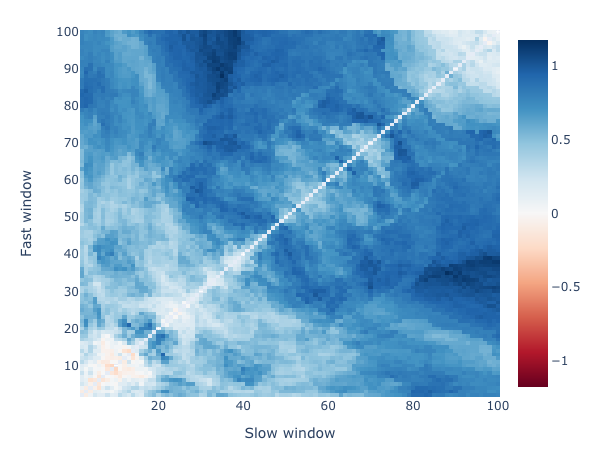

In [44]:
# For example, get mean performance for each window combination over all date ranges
heatmap_index = dmac_roll_perf.index.levels[0]
heatmap_columns = dmac_roll_perf.index.levels[2]
heatmap_df = pd.DataFrame(np.nanmean(dmac_perf_cube, axis=2), index=heatmap_index, columns=heatmap_columns)
heatmap_df = heatmap_df.vbt.make_symmetric()

heatmap_df.vbt.Heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window', 
    trace_kwargs=dict(zmid=0, colorscale='RdBu'), 
    width=600, height=450).show_png()

This image alone tells much more than the net profit heatmaps we plotted above!

8 20 71 75


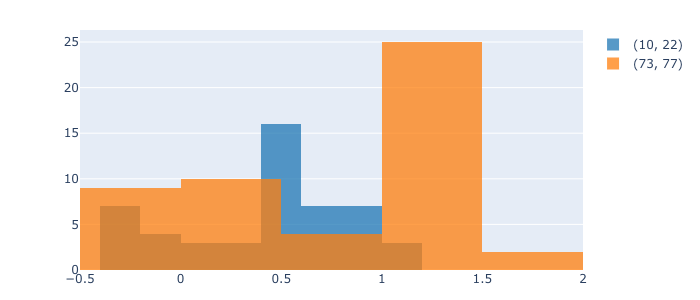

In [45]:
# Or for example, compare a pair of window combinations using a histogram
window_comb1 = (10, 22)
window_comb2 = (73, 77)

# Get index of each window in strat_cube
fast1_idx = np.where(heatmap_df.index == window_comb1[0])[0][0]
slow1_idx = np.where(heatmap_df.columns == window_comb1[1])[0][0]
fast2_idx = np.where(heatmap_df.index == window_comb2[0])[0][0]
slow2_idx = np.where(heatmap_df.columns == window_comb2[1])[0][0]

print(fast1_idx, slow1_idx, fast2_idx, slow2_idx)

dmac_comb1_perf = dmac_perf_cube[fast1_idx, slow1_idx, :]
dmac_comb2_perf = dmac_perf_cube[fast2_idx, slow2_idx, :]

pd.DataFrame({str(window_comb1): dmac_comb1_perf, str(window_comb2): dmac_comb2_perf}).vbt.Histogram().show_png()

Now the fun part.

Is our DMAC strategy really better than a simple random or hold strategy? To make any conclusions, we need to perform multiple tests over multiple time ranges (similar to how we compared window combinations earlier). And to make this experiment fair, all strategies must have the same number of tests. Moreover, the random strategy must have the same number of entry and exit signals as in our DMAC strategy.

In [46]:
%%time
# Hold strategy applied on rolled price
# Entry at the beginning, no exit
hold_entries_roll = pd.DataFrame.vbt.signals.empty_like(dmac_entries_roll)
hold_entries_roll.iloc[0, :] = True
hold_exits_roll = pd.DataFrame.vbt.signals.empty_like(hold_entries_roll)

hold_roll_portfolio = vbt.Portfolio.from_signals(open_roll, hold_entries_roll, hold_exits_roll)

hold_roll_perf = getattr(hold_roll_portfolio, metric)

print(hold_roll_perf.shape)
print(hold_roll_perf.index)

(242550,)
MultiIndex([( 2, False,   3, False, '2017-09-22'),
            ( 2, False,   3, False, '2017-10-02'),
            ( 2, False,   3, False, '2017-10-12'),
            ( 2, False,   3, False, '2017-10-22'),
            ( 2, False,   3, False, '2017-11-01'),
            ( 2, False,   3, False, '2017-11-10'),
            ( 2, False,   3, False, '2017-11-20'),
            ( 2, False,   3, False, '2017-11-30'),
            ( 2, False,   3, False, '2017-12-10'),
            ( 2, False,   3, False, '2017-12-20'),
            ...
            (99, False, 100, False, '2018-10-23'),
            (99, False, 100, False, '2018-11-02'),
            (99, False, 100, False, '2018-11-12'),
            (99, False, 100, False, '2018-11-22'),
            (99, False, 100, False, '2018-12-02'),
            (99, False, 100, False, '2018-12-11'),
            (99, False, 100, False, '2018-12-21'),
            (99, False, 100, False, '2018-12-31'),
            (99, False, 100, False, '2019-01-10'),
     

In [47]:
%%time
# Random strategy applied on rolled price
# Shuffle entries to get random entry signals of the same shape and cardinality
rand_entries_roll = dmac_entries_roll.vbt.signals.shuffle(seed=seed)

# Must have the same number of signals
pd.testing.assert_series_equal(rand_entries_roll.sum(axis=0), dmac_entries_roll.sum(axis=0))

# If we generate exits the same way as entries, we will get multiple exits between entries
# This is the correct way to generate ONLY ONE exit between two entries
rand_exits_roll = rand_entries_roll.vbt.signals.random_exits(1, seed=seed)

rand_roll_portfolio = vbt.Portfolio.from_signals(open_roll, rand_entries_roll, rand_exits_roll)

rand_roll_perf = getattr(rand_roll_portfolio, metric)

print(rand_roll_perf.shape)
print(rand_roll_perf.index)

(242550,)
MultiIndex([( 2, False,   3, False, '2017-09-22'),
            ( 2, False,   3, False, '2017-10-02'),
            ( 2, False,   3, False, '2017-10-12'),
            ( 2, False,   3, False, '2017-10-22'),
            ( 2, False,   3, False, '2017-11-01'),
            ( 2, False,   3, False, '2017-11-10'),
            ( 2, False,   3, False, '2017-11-20'),
            ( 2, False,   3, False, '2017-11-30'),
            ( 2, False,   3, False, '2017-12-10'),
            ( 2, False,   3, False, '2017-12-20'),
            ...
            (99, False, 100, False, '2018-10-23'),
            (99, False, 100, False, '2018-11-02'),
            (99, False, 100, False, '2018-11-12'),
            (99, False, 100, False, '2018-11-22'),
            (99, False, 100, False, '2018-12-02'),
            (99, False, 100, False, '2018-12-11'),
            (99, False, 100, False, '2018-12-21'),
            (99, False, 100, False, '2018-12-31'),
            (99, False, 100, False, '2019-01-10'),
     

In [48]:
dmac_roll_perf.mean(), hold_roll_perf.mean(), rand_roll_perf.mean()

(0.6774315382463152, 0.3197060193973544, 0.12017308403172199)

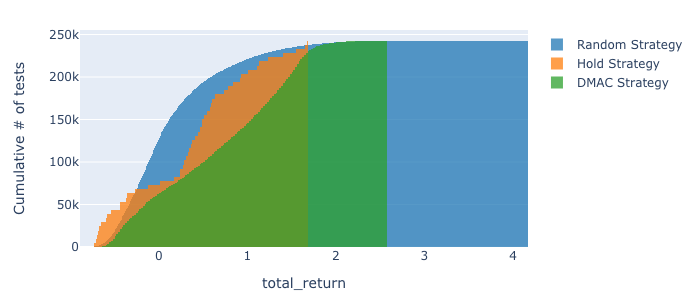

In [49]:
pd.DataFrame({
    'Random Strategy': rand_roll_perf, 
    'Hold Strategy': hold_roll_perf,
    'DMAC Strategy': dmac_roll_perf, 
}).vbt.Histogram(
    xaxis_title=metric,
    yaxis_title='Cumulative # of tests',
    trace_kwargs=dict(cumulative_enabled=True)).show_png()

The lower the curve, the better.

To get more insights, we should compare them over time.

In [50]:
pd.DataFrame({
    'Random strategy': rand_roll_perf.groupby('start_date').mean(), 
    'Hold strategy': hold_roll_perf.groupby('start_date').mean(),
    'DMAC strategy': dmac_roll_perf.groupby('start_date').mean()
}).vbt.Scatter(
    xaxis_title='Start date',
    yaxis_title='Mean %s' % metric).show_png()

You can go further and plot the above graph for each window combination.

In [51]:
windows_slider = widgets.IntRangeSlider(
    value=(fast_window, slow_window),
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)

scatter_fig = vbt.Scatter(
    dmac_roll_perf.index.get_level_values('start_date').unique(),
    ['Random strategy', 'Hold strategy', 'DMAC strategy'],
    xaxis_title='Start date',
    yaxis_title='Mean %s' % metric
)
scatter_img = widgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)

def on_value_change(value):
    fast_window, slow_window = value['new']
    
    # Build boolean mask that acts like a filter
    fast_windows = dmac_roll_perf.index.get_level_values('fast_ma_window')
    slow_windows = dmac_roll_perf.index.get_level_values('slow_ma_window')
    mask = (fast_windows == fast_window) & (slow_windows == slow_window)
    
    # Return raw data
    new_data = np.asarray([
        rand_roll_perf[mask].groupby('start_date').mean(),
        hold_roll_perf[mask].groupby('start_date').mean(),
        dmac_roll_perf[mask].groupby('start_date').mean()
    ]).transpose()

    # Update figures
    scatter_fig.update_data(new_data)
    scatter_img.value = scatter_fig.to_image(format="png")
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value}) # default range

widgets.VBox([
    widgets.HBox([
        widgets.Label('Fast and slow window:'), 
        windows_slider
    ]), 
    scatter_img
])

In [52]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

In [53]:
import gc

gc.collect()

65235